In [25]:
print("Importing...")
from GCN import *
from datetime import datetime
from Utils.my_utils import *
from Utils.util import *
import time
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
import os
import math
from train_utils import *

torch.manual_seed(124)
np.random.seed(124)
print("Done importing")

Importing...
Done importing


In [26]:
print("Settings")

run_folder="../"
dataset = "Test_dataset"
STEP_dataset= "D:\\3DStepGraphClassification\\Datasets"
graphml_dataset = "D:\\3DStepGraphClassification\\Graphml\\"
learning_rate=0.0005
batch_size=1
num_epochs=100
dropout=0.5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("The calculations will be performed on the device:", device)

# save paths
model_name = dataset + "_" + str(datetime.today().strftime('%m-%d'))
out_dir = os.path.abspath(os.path.join(run_folder, "./results/runs_GCN", dataset))
if not os.path.exists(out_dir + "/Models/"):
    os.makedirs(out_dir + "/Models/")
save_path = out_dir + "/Models/" + model_name
print("Results will be saved in:", out_dir)
print("    The model will be saved as:", save_path)

Settings
The calculations will be performed on the device: cuda:0
Results will be saved in: d:\3DStepGraphClassification\results\runs_GCN\Test_dataset
    The model will be saved as: d:\3DStepGraphClassification\results\runs_GCN\Test_dataset/Models/Test_dataset_04-21


### CONVERT STEP 3D Models to GRAPHS
To convert STEP models into Graphml data we use the **make_graphh_dataset** Python scripts. It generates an indirect graph from each STEP file.
The function takes two input: 1) the path of the STEP dataset and 2) the output directory where it's gonna write the graph dataset.
To avoid generating each graphs every run, the graph are saved as a **.graphml** format and then reload at subsequent runs.

In [20]:
import sys
sys.path.append('D:\\3DStepGraphClassification\\Graph_classification\\Graph_convertion')

from step_2_graph import make_graphh_dataset
# from Parser.Make_graph import make_graph_simplex_direct

print("Converting STEP dataset in Graphml dataset")
make_graphh_dataset(os.path.abspath(os.path.join(run_folder,"Datasets",STEP_dataset)), os.path.abspath(os.path.join(run_folder,"Datasets",graphml_dataset)))
print("Done converting")

Converting STEP dataset in Graphml dataset
Loading 01_Shaft/LSBJF32-1000-MD10-ND6-GLC2-HLC2.stp graph
Loading 01_Shaft/LSBJF32-1000-MD10-ND6-GLC2-HLC20.stp graph
Loading 01_Shaft/LSBJF32-1000-MD10-ND6-GLC20-HLC2.stp graph
Loading 01_Shaft/LSBJF32-1000-MD10-ND6-GLC20-HLC20.stp graph
Loading 01_Shaft/LSBJF32-1000-MD8-ND10-GLC2-HLC2.stp graph
Loading 01_Shaft/LSBJF32-1000-MD8-ND10-GLC2-HLC20.stp graph
Loading 01_Shaft/LSBJF32-1000-MD8-ND10-GLC20-HLC2.stp graph
Loading 01_Shaft/LSBJF32-1000-MD8-ND10-GLC20-HLC20.stp graph
Loading 01_Shaft/LSBJF32-1000-MD8-ND12-GLC2-HLC2.stp graph
Loading 01_Shaft/LSBJF32-1000-MD8-ND12-GLC2-HLC20.stp graph
Loading 01_Shaft/LSBJF32-1000-MD8-ND12-GLC20-HLC20.stp graph
Loading 01_Shaft/LSBJF32-1000-MD8-ND16-GLC2-HLC2.stp graph
Loading 01_Shaft/LSBJF32-1000-MD8-ND16-GLC2-HLC20.stp graph
Loading 01_Shaft/LSBJF32-1000-MD8-ND16-GLC20-HLC2.stp graph
Loading 01_Shaft/LSBJF32-1000-MD8-ND16-GLC20-HLC20.stp graph
Loading 01_Shaft/LSBJF32-1000-MD8-ND20-GLC2-HLC2.stp grap

### We load the graph dataset
The list of all graph is loaded and divided in train, test and validation set

In [21]:
# import sys
# sys.path.append('D:\\3DStepGraphClassification\\Graph_classification\\Utils\\')

print("Loading Graph data...")
use_degree_as_tag = False
fold = 0
graphs, num_classes = my_load_data(graphml_dataset, use_degree_as_tag)

train_graphs, test_graphs = separate_data(graphs, fold)
train_graphs, valid_graphs = split_data(train_graphs, perc=0.9)
print("# training graphs: ", len(train_graphs))
print_data_commposition(train_graphs)
print("# validation graphs: ", len(valid_graphs))
print_data_commposition(valid_graphs)
print("# test graphs: ", len(test_graphs))
print_data_commposition(test_graphs)
# Num of different STEP entities founded in the graph dataset
feature_dim_size = graphs[0].node_features.shape[1]
print("Loading data... finished!")

Loading Graph data...
Data Path= D:\3DStepGraphClassification\Graphml\
Loading class: 01_Shaft
Loading class: 02_HingePin
Loading class: 03_ConvexBendPlates
Loading class: 04_LBrackets
Loading class: 05_LinearBush
Loading class: 06_Ribs
Loading class: 07_RoundPlates
Loading class: 08_SupportUnit
Loading class: 09_ZPlates
Loading class: 10_Washer
# classes: 10
# maximum node tag: 71
# data: 1966
# training graphs:  1592
class: 0  - num elements: 162  - elements:  ['LSBJF32-1000-MD10-ND6-GLC2-HLC20.graphml', 'PLSBL30-1000-F30-M20-N20.graphml', 'PSFGH40-25-F148-P37-M10-T148.graphml', 'PSFGH40-25-F148-P37-M8-T148.graphml', 'LSBJF32-1000.0-MD8-ND12-GLC2.0-HLC20.graphml', 'LSBJF32-1000-MD8-ND12-GLC2-HLC20.graphml', 'PSFGH16-25-F2-P14-M10-T56.graphml', 'PSFGH40-25-F148-P37-M12-T148.graphml', 'LSBJF32-1000.0-MD8-ND10-GLC2.0-HLC20.graphml', 'SLSBP24-700-F80-G80-M10-N8.graphml', 'SFIG20-30-F68-P17-M6-N6.graphml', 'PSFUH35-25-F128-P32-M8-T2.graphml', 'PSFGA40-25-F148-P37-M30-N20.graphml', 'PSSFGA

### Model
We create a Graph Convolutional Neural Network model: the convolutional layers are followed by an attention mechanism and finally by fully connected layers.

In [22]:
print("Creating model")

# Create a GCN model
model = GCN_CN_v4(feature_dim_size=feature_dim_size, num_classes=num_classes, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_batches_per_epoch = int((len(train_graphs) - 1) / batch_size) + 1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=num_batches_per_epoch, gamma=0.1)

Creating model


print("Main process")

print("Writing to {}\n".format(out_dir))
# Checkpoint directory
checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
checkpoint_prefix = os.path.join(checkpoint_dir, "model")
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
write_acc = open(checkpoint_prefix + '_acc.txt', 'w')

train_losses = []
train_accuracy = []
valid_losses = []
valid_accuracy = []
valid_accuracy_x_class = []

best_loss = math.inf
best_accuracy = 0
# Train loop
for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()
    # train model
    train(mmodel=model, optimizer=optimizer, train_graphs=train_graphs, batch_size=batch_size, num_classes=num_classes, device=device)
    # evaluate on train data
    train_loss, train_acc, _ = evaluate(mmodel=model, current_graphs=train_graphs, batch_size=batch_size, num_classes=num_classes, device=device, out_dir=out_dir)
    # evaluate on validation data
    valid_loss, valid_acc, valid_acc_x_class = evaluate(mmodel=model, current_graphs=valid_graphs, batch_size=batch_size, num_classes=num_classes, device=device, out_dir=out_dir)
    print('| epoch {:3d} | time: {:5.2f}s | train loss {:5.2f} | valid loss {:5.2f} | valid acc {:5.2f} | '.format(epoch, (time.time() - epoch_start_time), train_loss, valid_loss, valid_acc*100))

    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracy.append(valid_acc)
    valid_accuracy_x_class.append(valid_acc_x_class)

    # Make a step of the optimizer if the mean of the last 6 epochs were better than the current epoch
    if epoch > 5 and train_losses[-1] > np.mean(train_losses[-6:-1]):
        scheduler.step()
        print("Scheduler step")
    # save if best performance ever
    if best_accuracy < valid_acc or (best_accuracy == valid_acc and best_loss > valid_loss):
        print("Save at epoch: {:3d} at valid loss: {:5.2f} and valid accuracy: {:5.2f}".format(epoch, valid_loss, valid_acc*100))
        best_accuracy = valid_acc
        best_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    write_acc.write('epoch ' + str(epoch) + ' fold ' + str(fold) + ' acc ' + str(valid_acc*100) + '%\n')

print("Finished training")

Plot results
Accuracy per class :
[ 95.         100.         100.         100.         100.
  95.          88.23529412 100.         100.         100.        ]
Evaluate: loss on test:  0.5955346753149469  and accuracy:  97.96954314720813


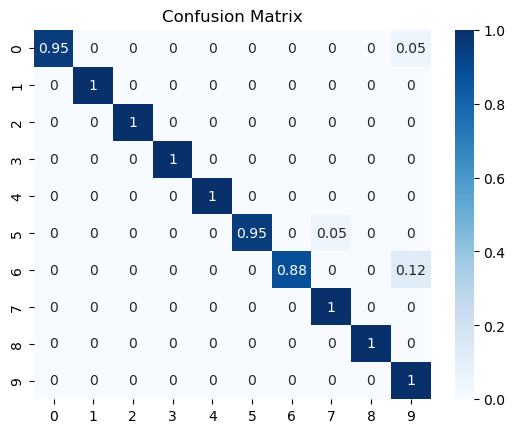

In [27]:
print("Plot results")

valid_accuracy_x_class = np.array(valid_accuracy_x_class).T
# plot training flow
plot_training_flow(ys=[train_losses, valid_losses], names=["train", "validation"], path=out_dir, fig_name="/losses_flow", y_axis="Loss")
plot_training_flow(ys=[np.array(train_accuracy)*100, np.array(valid_accuracy)*100], names=["train","validation"], path=out_dir, fig_name="/accuracy_flow", y_axis="Accuracy")
# Evaluate on test data
model.load_state_dict(torch.load(save_path))
test_loss, test_acc, _ = evaluate(mmodel=model, current_graphs=test_graphs, batch_size=batch_size, num_classes=num_classes, device=device, out_dir=out_dir, last_round=True)
print("Evaluate: loss on test: ", test_loss, " and accuracy: ", test_acc * 100)

write_acc.close()